In [1]:
# Process BES Panel for Wave 8

## WORK IN PROGRESS - run this on all updated BES waves

# Assign types to each column variables (mostly automatic - but there's room for manual editing)
# Modifies categories (harmoning options, harmonising order, dropping weasel terms)
# Creates:
# var_type (types for column variables)
# BES_numeric (fixed version with only useful columns all transformed into numeric values)
    # non-numeric categorical values -> index number of category
    # floats -> float
    # numeric categories (i.e. income intervals/number of children) -> numeric
# cat_dictionary
    # so you can get the text categories back from the index values as and when it's necessary
# BES_non_numeric
    # basically everything else! (mostly meta-data - weights)

# LIVE: Run all cells -> ~20s

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

# from sklearn import datasets
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

# from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE

In [3]:
%%time
# Load BES Panel for Wave 8
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W10_Panel_v0.3.dta") # 130Mb


#(31409, 733)

# BES_Panel = pd.read_stata(BES_data_folder+BES2015_W8_v1.6.dta")

print( BES_Panel.shape )

(64689, 4247)
Wall time: 10min 28s


In [94]:
%%time
## HELPER FUNCTIONS / REPLACEMENT VALUE DICTIONARIES


# changing the order of some sets of categories
change_cat_dict = {"Bad time to buy|Good time to buy|Neither good nor bad time to buy|Don't know": ["Bad time to buy",
                                                                                                    "Neither good nor bad time to buy",
                                                                                                    "Good time to buy",
                                                                                                    "Don't know"],
                   "Larger|Smaller|About the same|Don't know": ["Larger", "About the same", "Smaller","Don't know"],
                   "Yes|No|99.0":       ['No', 'Yes', '99.0'],
                   "Yes|No|Don't know": ['No', 'Yes', "Don't know"],
                   "Yes|No" :           ['No', 'Yes'],
                   "Yes, voted|No, did not vote|Donâ??t know" : ['No, did not vote', 'Yes, voted', 'Donâ??t know'],
                   "Yes, voted|No, did not vote|Don?t know"   : ['No, did not vote', 'Yes, voted', 'Don?t know'],                   
                   "I would/will not vote|Leave the EU|Stay/remain in the EU|Don't know": ['Stay/remain in the EU',
                                                                                           'Leave the EU', 'I would/will not vote', "Don't know"],
                   "Mainly leave|Mainly remain|Fairly evenly divided|Don't know": ["Mainly remain",
                                                                                   "Fairly evenly divided", "Mainly leave", "Don't know"],
                   "An individual share in a company|A portfolio of different company shares|The risk is the same|Don't know|Prefer not to say":
                       ['An individual share in a company', 'The risk is the same', 'A portfolio of different company shares',"Prefer not to say","Don't know"],
                   'An individual share in a company|A portfolio of different company shares|The risk is the same|Don\x92t know|Prefer not to say':
                       ['An individual share in a company', 'The risk is the same', 'A portfolio of different company shares',"Prefer not to say","Don\x92t know"],
                   "No, I have never been a member|Yes, I am a member of a party|I am not a member now but I used to be|Don't know":
                       ['No, I have never been a member', 'I am not a member now but I used to be', 'Yes, I am a member of a party', "Don't know"],
                   "Never or practically never|Less often than once a year|Less often but at least once a year|Less often but at least twice a year|Less often but at least once a month|Less often but at least once in two weeks|Once a week or more|Varies too much to say|I am not religious|Don't know":
                       ['I am not religious', 'Never or practically never', 'Less often than once a year',
                        'Less often but at least once a year', 'Less often but at least twice a year',
                        'Less often but at least once a month', 'Less often but at least once in two weeks',
                        'Once a week or more', "Varies too much to say","Don't know"],
                   "under Â£5,000 per year|Â£5,000 to Â£9,999 per year|Â£10,000 to Â£14,999 per year|Â£15,000 to Â£19,999 per year|Â£20,000 to Â£24,999 per year|Â£25,000 to Â£29,999 per year|Â£30,000 to Â£34,999 per year|Â£35,000 to Â£39,999 per year|Â£40,000 to Â£44,999 per year|Â£45,000 to Â£49,999 per year|Â£50,000 to Â£59,999 per year|Â£60,000 to Â£69,999 per year|Â£70,000 to Â£99,999 per year|Â£100,000 to Â£149,999 per year|Â£150,000 and over|Don't know|Prefer not to answer":
                       ["under Â£5,000 per year","Â£5,000 to Â£9,999 per year","Â£10,000 to Â£14,999 per year","Â£15,000 to Â£19,999 per year",
                        "Â£20,000 to Â£24,999 per year","Â£25,000 to Â£29,999 per year","Â£30,000 to Â£34,999 per year",
                        "Â£35,000 to Â£39,999 per year","Â£40,000 to Â£44,999 per year","Â£45,000 to Â£49,999 per year",
                        "Â£50,000 to Â£59,999 per year","Â£60,000 to Â£69,999 per year","Â£70,000 to Â£99,999 per year",
                        "Â£100,000 to Â£149,999 per year","Â£150,000 and over","Prefer not to answer","Don't know"],
                   "1|2|3|4|5|6|7|8 or more|Don't know|Prefer not to say":
                       ["1","2","3","4","5","6","7","8 or more","Prefer not to say","Don't know"],
                   "The Yes side|The No side|Neither|Don't know":
                       ["The Yes side","Neither","The No side","Don't know"] # is this ordinal - meh?
                   
                  }

# Big set of actual answers **I interpet** as non-answers (and set to NaN)
# REALLY MERITS RECHECKING WHAT THE IMPACT OF THIS IS!
Weasel_answers = ["Don't know", 'Do\x92t know', 'Dont know', 'Donât know', 'Don??t know',
                  "Prefer not to say", "Prefer not to answer", "Refused", "Unknown",
                  "Neither", "Other", "I would/will not vote", "Will not vote",
                  "I would not vote", "It depends", "Other",
                  "Don’t follow politics on Facebook", "Don't follow politics on twitter",
                  "Yes, other", "Haven't thought about it",
                  "There wasn't a local election in my area", "No, haven't received it",
                  "I don't know what was negotiated", "I never received a response",
                  "There are not local elections in my area", "Can't remember",
                  "Varies too much to say", "Will not state a choice",
                  "All leaders equally good", "They are not eligible to vote",
                  "There are not local elections in my area", "Both/neither"]

# BES codes for NaN
Weasel_number_answers = [ "9999.0", "997.0", "222.0", "99.0", "0.0" ]

# non-answer answers
Weasel_set = set(Weasel_answers) # gets rid of duplicates!


## define 'de_Weasel' function to remove Weasel Words from lists of options
## ie. "Yes|No|Don't know" -> "Yes|No"

Weasel_answers = ["Don't know", 'Don?t know', 'Donâ??t know', 'Do\x92t know', 'Dont know', 'Donât know', "Prefer not to say", "Prefer not to answer", "Refused", "Unknown", "Neither", "Other", "I would/will not vote", "Will not vote", "No - not decided", "I would not vote", "It depends", "Other", "Don’t follow politics on Facebook", "Don't follow politics on twitter", "9999.0", "997.0", "222.0", "Yes, other", "Haven't thought about it", "There wasn't a local election in my area", "No, haven't received it", "I don't know what was negotiated", "I never received a response", "There are not local elections in my area", "Can't remember", "Varies too much to say" ]

# non-answer answers
Weasel_set = set(Weasel_answers) # gets rid of duplicates!

# remove weasel phrases
def de_weasel(ques): 

    return "|".join( [x for x in ques.split("|") if x not in Weasel_answers] )

# reorder categories
def re_order(ques):
    if ques in change_cat_dict.keys():
        return "|".join( change_cat_dict[ques] )
    else:
        return ques

def de_num_el(el):
    if el.isdigit():
        el = "%.1f" % int( el )
    return el

def de_number(ques):
    return "|".join( [de_num_el(x) for x in ques.split("|")] )

def de_num(ques):
    return [de_num_el(x) for x in ques]

def floatable(flt):
    try:
        float(flt)
        return True
    except:
        return False

# Weasel_number_answers
# Remove 'weasel' numbers
# but only if they are the last element
# or not the last element, but the next is not a number
# to avoid catching parts of sequential numerical categories
def de_weasel_numbers(ques):
    el_list = ques.split("|")
    el_list_len = len(el_list)
    remove_list = []
    for el_pos in range( 0, el_list_len ):
        if el_list[el_pos] in Weasel_number_answers:
            # last element, or not last element but next element is a not a number
            if el_pos==(el_list_len-1) or not floatable(el_list[el_pos+1]):
                remove_list.append(el_list[el_pos])

    return "|".join( [x for x in el_list if x not in remove_list] )


# version to act directly on cat.categories array
def de_weasel_nums(el_list):

    el_list_len = len(el_list)
    remove_list = []
    for el_pos in range( 0, el_list_len ):
        if el_list[el_pos] in Weasel_number_answers:
            # last element, or not last element but next element is a not a number
            if el_pos==(el_list_len-1) or not floatable(el_list[el_pos+1]):
                remove_list.append(el_list[el_pos])

    return remove_list

# s.cat.rename_categories([1,2,3])
# EUContactRemainConW8|EUContactRemainLabW8|EUContactRemainLDW8|
# EUContactRemainSNPW8|EUContactRemainPCW8|EUContactRemainUKIPW8|
# EUContactRemainGreenW8|EUContactRemainOthW8|EUContactRemainNoneW8|
# EUContactRemainDKW8|EUContactLeaveConW8|EUContactLeaveLabW8|
# EUContactLeaveLDW8|EUContactLeaveSNPW8|EUContactLeavePCW8|
# EUContactLeaveUKIPW8|EUContactLeaveGreenW8|EUContactLeaveOthW8|
# EUContactLeaveNoneW8|EUContactLeaveDKW8

# pattern match "EUContact*****W8"
# debateOneWatchW8|debateTwoWatchW8

# "1.0|2.0|99.0" -> 

# euRefVoteSqueezeW7 "Will not vote|Yes - Leave|Yes - Remain|No - not decided"
#    -> Stay/remain in the EU|Leave the EU|I would/will not vote|Don't know
#    HMM - RENAME AND REORDER!

# miieuW7
# "Issue stated|Nothing|Don't know" -> "Issue stated|None|Don't know"
# MIIEUW8
# "1.0|Nothing|Don't know" -> "Issue stated|None|Don't know"
# partyIdEUW7|partyIdEUW8
# "Mainly leave|Mainly remain|Fairly evenly split|Don't know" -> "Mainly remain|Fairly evenly divided|Mainly leave|Don't know"
#    HMM - RENAME AND REORDER!

# 1. campaignVisionYesW3|campaignVisionNoW3, govtNatSecuritySuccessW4
# Very unsuccessful|Fairly unsuccessful|Neither successful nor unsuccessful|Fairly successful|Very successful|Don't know
# Very unsuccessful|Somewhat unsuccessful|Neither successful or unsuccessful|Somewhat successful|Very successful|Don't know

# Fairly <-> Somewhat

# 2. euroTurnoutW1, scotReferendumTurnoutW1|scotReferendumTurnoutW2|welshTurnoutW7|scotTurnoutW7, turnoutUKGeneralW1|turnoutUKGeneralW2|turnoutUKGeneralW3|turnoutUKGeneralW4|turnoutUKGeneralW5|euRefTurnoutW7|euRefTurnoutW8
# Very unlikely that I vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I vote|Don't know
# Very unlikely that I would vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I would vote|Don't know
# There are not local elections in my area
    #|Very unlikely that I will vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I will vote|Don't know
# Very unlikely that I will vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I will vote|Don't know

# "Very unlikely that I vote", "Very unlikely that I would vote" ->  "Very unlikely that I will vote" 

rename_cat_dict = {"North East|North West": [ "No", "Yes" ],
                   "1.0|2.0|99.0": ["No", "Yes", "99.0"],
                   "Will not vote|Yes - Leave|Yes - Remain|No - not decided": ['I would/will not vote', 'Leave the EU',
                                                                               'Stay/remain in the EU', "Don't know"],
                   "Issue stated|Nothing|Don't know":  ['Issue stated', 'None', "Don't know"],
                   "1.0|Nothing|Don't know":           ['Issue stated', 'None', "Don't know"],
                   "a|b|C1|C2|d|e|Refused|Unknown" : ['A', 'B', 'C1', 'C2', 'D', 'E', 'Refused', 'Unknown'],
                   "Mainly leave|Mainly remain|Fairly evenly split|Don't know": ['Mainly leave',
                                                                                 'Mainly remain', 'Fairly evenly divided', "Don't know"],
                   "Very unsuccessful|Somewhat unsuccessful|Neither successful or unsuccessful|Somewhat successful|Very successful|Don't know": ['Very unsuccessful',
                        'Fairly unsuccessful', 'Neither successful nor unsuccessful', 'Fairly successful', 'Very successful', "Don't know"],
                   "Very unlikely that I vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I vote|Don't know":
                       ['Very unlikely that I will vote',
                     'Fairly unlikely', 'Neither likely nor unlikely', 'Fairly likely', 'Very likely that I will vote', "Don't know"],
                   "Very unlikely that I would vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I would vote|Don't know":
                       ['Very unlikely that I will vote', 'Fairly unlikely',
                        'Neither likely nor unlikely', 'Fairly likely', 'Very likely that I will vote', "Don't know"],
                   "No, did not vote|Yes, voted|3.0|4.0|5.0|Don't know":   
                       ["Very unlikely that I will vote", "Fairly unlikely",
                        "Neither likely nor unlikely", "Fairly likely", "Very likely that I will vote", "Don't know"], #londonTurnoutW7
                   "No, I do not regard myself as belonging to any particular religion.|Yes - Church of England/Anglican/Episcopal|Yes - Roman Catholic|Yes - Presbyterian/Church of Scotland|Yes - Methodist|Yes - Baptist|Yes - United Reformed Church|Yes - Free Presbyterian|Yes - Brethren|Yes - Judaism|Yes - Hinduism|Yes - Islam|Yes - Sikhism|Yes - Buddhism|Yes - Other|Prefer not to say|Yes â€“ Orthodox Christian|Yes - Pentecostal (e.g. Assemblies of God, Elim Pentecostal Church, New Testament Church of God, Redeemed Christian Chur|Yes - Evangelical â€“ independent/non-denominational (e.g. FIEC, Pioneer, Vineyard, Newfrontiers)":
                       ["No, I do not regard myself as belonging to any particular religion.","Yes - Church of England/Anglican/Episcopal",
                        "Yes - Roman Catholic","Yes - Presbyterian/Church of Scotland","Yes - Methodist","Yes - Baptist",
                        "Yes - United Reformed Church","Yes - Free Presbyterian","Yes - Brethren","Yes - Judaism","Yes - Hinduism",
                        "Yes - Islam","Yes - Sikhism","Yes - Buddhism","Yes - Other","Prefer not to say","Yes - Orthodox Christian",
                        "Yes - Pentecostal","Yes - Evangelical /independent/non-denominational"], #xprofile_religionW10
                   "Own â€“ outright|Own â€“ with a mortgage|Own (part-own) â€“ through shared ownership scheme (i.e. pay part mortgage, part rent)|Rent â€“ from a private landlord|Rent â€“ from my local authority|Rent â€“ from a housing association|Neither â€“ I live with my parents, family or friends but pay some rent to them|Neither â€“ I live rent-free with my parents, family or friends|Other":
                       ["Own outright","Own with a mortgage","Own (part-own) through shared ownership scheme (i.e. pay part mortgage, part rent)",
                        "Rent from a private landlord","Rent from my local authority","Rent from a housing association",
                        "Neither I live with my parents, family or friends but pay some rent to them",
                        "Neither I live rent-free with my parents, family or friends","Other"], #xprofile_house_tenureW10
                   }



def re_name(ques):
    if ques in rename_cat_dict.keys():
        return "|".join( rename_cat_dict[ques] )
    else:
        return ques

## COLUMNS THAT EITHER LACK ALL DATA OR HAVE ACTUAL ERRORS
# check back on these periodically - one assumes they will get fixed!
# maybe tell them about them so that they can?
ignore_list = ['approveEUW2',
               'whichPartiesHelped_99W6',
               'partyContactGrnW1',
               'partyContactGrnW2',
               'partyContactGrnW3',
               'reasonNotRegistered_noneW2',               
               'reasonNotRegistered_noneW3',
               'reasonNotRegistered_noneW4',
               'reasonNotRegistered_noneW6',
               'reasonNotRegistered_noneW7',
               'reasonNotRegistered_noneW8',
               'reasonNotRegistered_none',
               'partyContactSNPW1',
               'partyContactSNPW2',
               'changeIssue1W9',
               'conLeaderLikeW9',
               "locusControlW9",
               "generalElecCertaintyW1", # wave 10 forwards
               "generalElecCertaintyW2",
               "generalElecCertaintyW3",
               "londonMayorVoteW7",
               "fatherNumEmployeesW4",
               "motherNumEmployeesW4",
               "selfNumEmployeesW6W7W8W9",
               "selfNumEmployeesLastW6W7W8W9"
              ]

#- approveEUW2 'Strongly disapprove|Disapprove|Don't know' - should be "approve|disapprove|don't know"??? NOT SURE (distribution weird)
#- whichPartiesHelped_99W6 - answer set = ["No"]
#- partyContactGrnW1 ... reasonNotRegistered_noneW8 answer set = ["No", "Don't know"]
# -partyContactSNPW1, partyContactSNPW2 - answer set = ["Don't know"]
# -changeIssue1W9|conLeaderLikeW9|locusControlW9 - answer set = ["No formal qualifications"]

## define 'prune' function to prune wave indicators and return question stubs
## ie. "ptvConW1|ptvLabW1" -> "ptvCon|ptvLab"

def prune(x):
    
    y= []
    for el in x.split("|"):
        match_attempt = re.match('(\w*?)_?(W[0-9]+)+' , el )   
        if match_attempt:
            el = match_attempt.groups()[0]
        y.append(el)
    # should we ditch identical repeats?
    # return "|".join(set(y)) NEEDS TO BE TESTED
    return "|".join(y)

               
def prune2(x):
    
    y= []
    for el in x.split("|"):
        # fgdfhfghg_5, fgdfhfghg_4, fgdfhfghg_3 -> fgdfhfghg
        # problem - indicator variables fgdfhfghg_99, fgdfhfghg_111 really are different!
        # solution - leave them distinct
        indicator_variable = re.match('(\w*?)_?(99|111)' , el )       
        match_attempt = re.match('(\w*?)_?[0-9]+' , el )   
        if (not indicator_variable) and (match_attempt):
            el = match_attempt.groups()[0]
        y.append(el)
    # should we ditch identical repeats?
    # return "|".join(set(y)) NEEDS TO BE TESTED
    return "|".join(y)
#variable_categories

Wall time: 1 ms


In [95]:
variable_categories = pd.read_csv("question_categories_correct.csv", encoding = "ISO-8859-1")
variable_categories.drop('Unnamed: 0', axis=1,inplace=True)
# flipping list
var_cat_dict = dict()
for typ in [0,1,2,3,4,5,6,7]:
    # 
    e = variable_categories[variable_categories.type==typ]["column_name"].values
    var_cat_dict[typ] = [item for sublist in [i.split("|") for i in e] for item in sublist]
    var_cat_dict[typ] = [item for item in var_cat_dict[typ] if item not in ignore_list]
    
# dictionary comprehension to prune column-names to wave non-specific stubs
# list(set()) gets rid of repetitions
var_cat_dict_pruned   = {k: list(set([prune(x)  for x in v])) for k, v in var_cat_dict.items()}
var_cat_dict_pruned_2 = {k: list(set([prune2(x) for x in v])) for k, v in var_cat_dict_pruned.items()}

In [96]:
var_type = pd.DataFrame(columns = ['type'] )

missing_col_names = []

for col in BES_Panel.columns:
    dt =  BES_Panel[col].dtype.name # data type
    not_found = False
    
    if col in ignore_list: # exclude values from ignore_list
        var_type.loc[col] = -2
        
    elif (col == "id"): # id
         var_type.loc[col] = -5

    elif (dt == 'object'): # text
        var_type.loc[col] = -4

    elif ("datetime" in dt): # datetime
        var_type.loc[col] = -3           

    else:
        not_found = True

        for typ in [0,1,2,3,4,5,6,7]: 
            if prune2( prune(col) ) in var_cat_dict_pruned_2[typ]:
                var_type.loc[col] = typ
                not_found = False

    if not_found == True:
        var_type.loc[col] = -1
        #print("what's up with this? " + col, prune2( prune(col) ) )
        missing_col_names.append(col)
var_type["type"] = var_type["type"].astype("int8")
# missing_col_names

In [97]:
#######################################################################
## MANUAL FIXING OF COLUMN NAMES THAT DON'T ALREADY HAVE A TYPE
## Only works for category type variables (you may need to manually drop non-category columns!)
## Basically does it best to automatically guess the matching types (based on the near match of the {answer set})
## Appends them to the a copy of "questions_category_correct" named 'question_categories_correct_updatesneeded!.csv'
## Then I'm afraid you have to look at them, fix them if needed, and then run the code in the cell below again
manual_fixing = False
missing_col_names_cat_only = []
if manual_fixing:
    print("#######################################")
    print("CATEGORIES")
    print("#######################################")
    print("\n")
    for col in missing_col_names:
        if BES_Panel[col].dtypes.name == 'category':
            print(col)
            missing_col_names_cat_only.append(col)
    print("\n")
    print("\n")

    print("#######################################")
    print("NON CATEGORIES")
    print("#######################################")
    print("\n")
    for col in missing_col_names:
        if BES_Panel[col].dtypes.name != 'category':
            print(col)
    print("\n")
    print("\n")
    ## if this only shows "weight" variables, it's fine - set manual_fixing to false and ignore!

In [98]:
if manual_fixing:

    updated_variable_categories = variable_categories.copy()

    # question	frequency	question_length	question_options	column_name	type

    for i in missing_col_names_cat_only:
        str_list = [ str(cat) for cat in BES_Panel[i].cat.categories ]
        joined_list = "|".join(str_list)
        match  = (joined_list == updated_variable_categories["question"])
        # print(i, " : " , "|".join(str_list ), " : ", len(str_list) )
        if match.any(): # answer set already in records
            index = updated_variable_categories[match].index
            if len(index)>1: # answer set ("question") index should be unique!
                raise ValueError('answer set ("question") index should be unique!')

            # add column name and increase frequency
            updated_variable_categories.loc[index,"frequency"] = updated_variable_categories.loc[index,"frequency"]+1
            current_list_col_names = updated_variable_categories.loc[index,"column_name"].values[0].split("|")
            current_list_col_names.append(i)
            updated_variable_categories.loc[index,"column_name"] = "|".join( current_list_col_names )
        else: # answer set not already in records - add new line to dataframe
            df = pd.DataFrame([],  columns = updated_variable_categories.columns )

            # no need to add index
            # updated_variable_categories.shape[0], 
            df.loc[0] = [joined_list,
                         1,
                         len(joined_list),
                         len(str_list),
                         i,-1]
            updated_variable_categories = updated_variable_categories.append(df, ignore_index=True)

    variable_categories = updated_variable_categories
    updated_variable_categories.to_csv("question_categories_correct_updatesneeded!.csv", encoding = "ISO-8859-1")
    
    # rerun after updating list!
    
    #variable_categories = pd.read_csv("question_categories_correct.csv", encoding = "ISO-8859-1")

    # flipping list
    var_cat_dict = dict()
    for typ in [0,1,2,3,4,5,6,7]:
        e = variable_categories[variable_categories.type==typ]["column_name"].values
        var_cat_dict[typ] = [item for sublist in [i.split("|") for i in e] for item in sublist]

    # dictionary comprehension to prune column-names to wave non-specific stubs
    # list(set()) gets rid of repetitions
    var_cat_dict_pruned   = {k: list(set([prune(x)  for x in v])) for k, v in var_cat_dict.items()}
    var_cat_dict_pruned_2 = {k: list(set([prune2(x) for x in v])) for k, v in var_cat_dict_pruned.items()}        
        
    var_type = pd.DataFrame(columns = ['type'] )
    missing_col_names = []

    for col in BES_Panel.columns:
        dt =  BES_Panel[col].dtype.name # data type
        not_found = False
        if col in ignore_list: # exclude values from ignore_list
            var_type.loc[col] = -2
            
        elif (col == "id"): # id
            var_type.loc[col] = -5
            
        elif (dt == 'object'): # text
            var_type.loc[col] = -4

        elif ("datetime" in dt): # datetime
            var_type.loc[col] = -3          

        else:
            not_found = True

            for typ in [0,1,2,3,4,5,6,7]:
                if prune2( prune(col) ) in var_cat_dict_pruned_2[typ]:
                    var_type.loc[col] = typ
                    not_found = False

        if not_found == True:
            var_type.loc[col] = -1
            missing_col_names.append(col)
#             raise ValueError('Values still missing second time around! ', col)
    var_type["type"] = var_type["type"].astype("int8")
    display([x for x in zip(missing_col_names, BES_Panel[missing_col_names].dtypes)])

In [111]:
# %%time

# ditch ignore_list values
# ditch indicator values

num_cols     = BES_Panel.columns[ (var_type["type"].apply( lambda x: x in [0,1,2,3,5,6,7] )).values ]
non_num_cols = BES_Panel.columns[ (var_type["type"].apply( lambda x: x in [-5,-4,-3,-1 ] )).values ]

BES_numeric     = BES_Panel[num_cols].copy()


pos = 0
for col in BES_numeric:
    pos = pos + 1
#     print(col)
    
    if col not in var_type["type"].index:
        print(col, " not in var_type")
        continue
    typ = var_type["type"][col]
    
    if (typ==0) | (typ==7):
        continue
    
    # force all category elements into strings
    BES_numeric[col].cat.rename_categories( BES_numeric[col].cat.categories.map(str), inplace=True )
    
    # rename categories
    
    join_list = "|".join( BES_numeric[col].cat.categories )
    if join_list in rename_cat_dict.keys():
        BES_numeric[col].cat.rename_categories(  rename_cat_dict[join_list], inplace=True )
    # update join_list!
    
    # reorder categories
    join_list = "|".join( BES_numeric[col].cat.categories )
    if join_list in change_cat_dict.keys():
        BES_numeric[col].cat.reorder_categories( change_cat_dict[join_list], inplace=True )    
    
    # de_weasel numbers
    BES_numeric[col].cat.remove_categories( de_weasel_nums( BES_numeric[col].cat.categories ), inplace=True )
    
    # set all digits to floating point format, one decimal place
    BES_numeric[col].cat.rename_categories( de_num( BES_numeric[col].cat.categories ), inplace=True )
                                          
    # de_weasel                                   
    BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )


country
ukCitizenW1
euCitizenW1
commonwealthCitizenW1
otherCitizenW1
ageW1
bestOnMIIW1
turnoutUKGeneralW1
turnoutUKGeneralW2
turnoutUKGeneralW3
turnoutUKGeneralW4
turnoutUKGeneralW5
turnoutUKGeneralW7
turnoutUKGeneralW8
turnoutUKGeneralW9
turnoutUKGeneralW10
generalElectionVoteW1
generalElectionVoteW2
generalElectionVoteW3
generalElectionVoteW4
generalElectionVoteUnsqueezeW4
generalElectionVoteSqueezeW4
generalElectionVoteW5
generalElectionVotePostW5
generalElectionVoteUnsqueezeW5
generalElectionVoteSqueezeW5
generalElectionVoteW6
generalElectionVoteW7
generalElectionVoteW8
generalElectionVoteW9
generalElectionVoteW10
generalElectionCertaintyW1
generalElectionCertaintyW2
generalElectionCertaintyW3
generalElectionCertaintyW4
generalElectionCertaintyUnsqW5
generalElectionCertaintySqW5
generalElectionCertaintyW5
generalElectionCertaintyW9
generalElectionCertaintyW10
partyIdStrengthW1
partyIdW1
partyIdSqueezeW1
partyIdStrengthW2
partyIdW2
partyIdSqueezeW2
partyIdStrengthW3
partyIdW3
partyI

ptvLDW2
ptvSNPW2
ptvPCW2
ptvUKIPW2
ptvGrnW2
ptvBNPW2
responsibleDebtConservativesW2
responsibleDebtLiberalDemsW2
responsibleDebtLabourW2
responsibleDebtUKBanksW2
responsibleDebtGlobalBanksW2
responsibleDebtTradeUnionsW2
responsibleDebtEUW2
responsibleDebtOtherW2
responsibleDebtNoneW2
responsibleDebtDontKnowW2
cutsTooFarNationalW2
cutsTooFarNHSW2
cutsTooFarLocalW2
privatTooFarW2
enviroProtectionW2
changeEconomyW2
changeNHSW2
changeEducationW2
changeCostLiveW2
changeImmigW2
changeCrimeW2
responsibleEconConservativesW2
responsibleEconLibDemsW2
responsibleEconLabourW2
responsibleEconScottishGovtW2
responsibleEconWelshGovtW2
responsibleEconNoneW2
responsibleEconDontKnowW2
responsibleNHSConservativesW2
responsibleNHSLibDemsW2
responsibleNHSLabourW2
responsibleNHSScottishGovtW2
responsibleNHSWelshGovtW2
responsibleNHSNoneW2
responsibleNHSDontKnowW2
responsibleEducationConW2
responsibleEducationLDW2
responsibleEducationLabW2
responsibleEducationScotGovtW2
responsibleEducationWelshGovtW2
respon

csplPunishWrongsW2
expectGoodConductGeneralW2
currentUnionMemberW2
everUnionMemberW2
selfOccSuperviseW2
selfOccOrgSizeW2
selfOccSuperviseLastW2
selfOccOrgSizeLastW2
bestOnMIIW3
polAttentionW3
trustMPsW3
trustYourMPW3
likeCameronW3
likeMilibandW3
likeCleggW3
likeSalmondW3
likeWoodW3
likeFarageW3
goodTimePurchaseW3
riskPovertyW3
riskUnemploymentW3
econPersonalRetroW3
econGenRetroW3
likeConW3
likeLabW3
likeLDW3
likeSNPW3
likePCW3
likeUKIPW3
likeGrnW3
likeBNPW3
ptvConW3
ptvLabW3
ptvLDW3
ptvSNPW3
ptvPCW3
ptvUKIPW3
ptvGrnW3
ptvBNPW3
responsibleDebtConservativesW3
responsibleDebtLiberalDemsW3
responsibleDebtLabourW3
responsibleDebtUKBanksW3
responsibleDebtGlobalBanksW3
responsibleDebtTradeUnionsW3
responsibleDebtEUW3
responsibleDebtOtherW3
responsibleDebtNoneW3
responsibleDebtDontKnowW3
cutsTooFarNationalW3
cutsTooFarNHSW3
cutsTooFarLocalW3
privatTooFarW3
enviroProtectionW3
changeEconomyW3
changeNHSW3
changeEducationW3
changeCostLiveW3
changeImmigW3
changeCrimeW3
responsibleEconConservativesW

mapAsianW3
mapWhiteW3
mapUKBirthW3
diversityChangeW3
discussPolDaysW3
bestOnMIIW4
decidedVoteW4
polAttentionW4
trustMPsW4
trustYourMPW4
likeCameronW4
likeMilibandW4
likeCleggW4
likeSturgeonW4
likeWoodW4
likeFarageW4
likeBennettW4
mpLooksAfterConstInterestW4
winConstituencyConW4
winConstituencyLabW4
winConstituencyLDW4
winConstituencyUKIPW4
winConstituencyGreenW4
winConstituencySNPW4
winConstituencyPCW4
preferConCoalitionW4
preferConMajorityW4
preferLabCoalitionW4
preferLabMajorityW4
preferOtherGovW4
noChanceCoalitionLabW4
noChanceCoalitionConW4
noChanceCoalitionLDW4
noChanceCoalitionSNPW4
noChanceCoalitionPCW4
noChanceCoalitionGrnW4
noChanceCoalitionUKIPW4
noChanceCoalitionNoneW4
labPartnerLDW4
labPartnerSNPW4
labPartnerPCW4
labPartnerGreenW4
labPartnerUKIPW4
conPartnerLDW4
conPartnerSNPW4
conPartnerPCW4
conPartnerGreenW4
conPartnerUKIPW4
majorityPartyConW4
majorityPartyLabW4
goodTimePurchaseW4
riskPovertyW4
riskUnemploymentW4
econPersonalRetroW4
econGenRetroW4
likeConW4
likeLabW4
like

labHandleLevelCrimeW4
conPriorities_econW4
conPriorities_costLiveW4
conPriorities_nhsW4
conPriorities_immigW4
conPriorities_crimeW4
conPriorities_schoolW4
conPriorities_noneW4
labPriorities_econW4
labPriorities_costLiveW4
labPriorities_nhsW4
labPriorities_immigW4
labPriorities_crimeW4
labPriorities_schoolW4
labPriorities_noneW4
ldPriorities_econW4
ldPriorities_costLiveW4
ldPriorities_nhsW4
ldPriorities_immigW4
ldPriorities_crimeW4
ldPriorities_schoolW4
ldPriorities_noneW4
ukipPriorities_econW4
ukipPriorities_costLiveW4
ukipPriorities_nhsW4
ukipPriorities_immigW4
ukipPriorities_crimeW4
ukipPriorities_schoolW4
ukipPriorities_noneW4
relationshipName1W4
relationshipName2W4
relationshipName3W4
discussantsSameAddress_1W4
discussantsSameAddress_2W4
discussantsSameAddress_3W4
discussPolDaysD1W4
discussPolDaysD2W4
discussPolDaysD3W4
discussantVoteName1W4
discussantVoteName2W4
discussantVoteName3W4
discussantturnoutName1W4
discussantturnoutName2W4
discussantturnoutName3W4
discussantApprovalVoteN

coalitionInTuneW6
coalitionDontDeliverW6
lr1W6
lr2W6
lr3W6
lr4W6
lr5W6
al1W6
al2W6
al3W6
al4W6
al5W6
conAngryW6
conHopeW6
conFearW6
conPrideW6
conNoneW6
labAngryW6
labHopeW6
labFearW6
labPrideW6
labNoneW6
ldAngryW6
ldHopeW6
ldFearW6
ldPrideW6
ldNoneW6
snpAngryW6
snpHopeW6
snpFearW6
snpPrideW6
snpNoneW6
pcAngryW6
pcHopeW6
pcFearW6
pcPrideW6
pcNoneW6
ukipAngryW6
ukipHopeW6
ukipFearW6
ukipPrideW6
ukipNoneW6
grnAngryW6
grnHopeW6
grnFearW6
grnPrideW6
grnNoneW6
dutyToVote2W6
socialPressureVoteW6
discussPolDaysW6
satDemUKW6
satDemScotW6
satDemWalesW6
satDemEngW6
satDemEUW6
electionInterestW6
partyContact1W6
partyContactConW6
partyContactLabW6
partyContactLDW6
partyContactSNPW6
partyContactPCW6
partyContactUKIPW6
partyContactGrnW6
partyContactOtherPartyW6
partyContactNoneW6
partyContactDKW6
partyContactCon_1W6
partyContactCon_2W6
partyContactCon_3W6
partyContactCon_4W6
partyContactCon_5W6
partyContactCon_6W6
partyContactCon_7W6
partyContactLab_1W6
partyContactLab_2W6
partyContactLab_3W6
partyC

partyContactSNP_5W7
partyContactSNP_6W7
partyContactSNP_7W7
partyContactPC_1W7
partyContactPC_2W7
partyContactPC_3W7
partyContactPC_4W7
partyContactPC_5W7
partyContactPC_6W7
partyContactPC_7W7
partyContactUKIP_1W7
partyContactUKIP_2W7
partyContactUKIP_3W7
partyContactUKIP_4W7
partyContactUKIP_5W7
partyContactUKIP_6W7
partyContactUKIP_7W7
partyContactGreen_1W7
partyContactGreen_2W7
partyContactGreen_3W7
partyContactGreen_4W7
partyContactGreen_5W7
partyContactGreen_6W7
partyContactGreen_7W7
partyContactOther_1W7
partyContactOther_2W7
partyContactOther_3W7
partyContactOther_4W7
partyContactOther_5W7
partyContactOther_6W7
partyContactOther_7W7
EUContactRemainConW7
EUContactRemainLabW7
EUContactRemainLDW7
EUContactRemainSNPW7
EUContactRemainPCW7
EUContactRemainUKIPW7
EUContactRemainGreenW7
EUContactRemainOthW7
EUContactRemainNoneW7
EUContactRemainDKW7
EUContactLeaveConW7
EUContactLeaveLabW7
EUContactLeaveLDW7
EUContactLeaveSNPW7
EUContactLeavePCW7
EUContactLeaveUKIPW7
EUContactLeaveGreenW7


partyContactOther_7W8
EUContactRemainConW8
EUContactRemainLabW8
EUContactRemainLDW8
EUContactRemainSNPW8
EUContactRemainPCW8
EUContactRemainUKIPW8
EUContactRemainGreenW8
EUContactRemainOthW8
EUContactRemainNoneW8
EUContactRemainDKW8
EUContactLeaveConW8
EUContactLeaveLabW8
EUContactLeaveLDW8
EUContactLeaveSNPW8
EUContactLeavePCW8
EUContactLeaveUKIPW8
EUContactLeaveGreenW8
EUContactLeaveOthW8
EUContactLeaveNoneW8
EUContactLeaveDKW8
leaveToneW8
remainToneW8
proConRemainW8
proConLeaveW8
campaigninfoLeaveW8
campaigninfoRemainW8
immigrantsWelfareStateW8
prefTradeoffW8
beliefTradeoffW8
controlImmigW8
satDemUKW8
satDemScotW8
satDemWalesW8
satDemEngW8
satDemEUW8
riskTakingW8
immigEconW8
immigCulturalW8
asylumMoreW8
euMoreW8
noneuMoreW8
studentsMoreW8
familiesMoreW8
immigSelfW8
immigConW8
immigLabW8
immigLDW8
immigSNPW8
immigPCW8
immigUKIPW8
immigGreenW8
registeredW8
registeredUpToDateW8
reasonNotRegistered_1W8
reasonNotRegistered_2W8
reasonNotRegistered_3W8
reasonNotRegistered_4W8
reasonNotRegi

changeEconomyLabW10
changeNHSLabW10
changeEducationLabW10
changeCostLiveLabW10
changeImmigLabW10
changeCrimeLabW10
leftRightW10
lrConW10
lrLabW10
lrLDW10
lrUKIPW10
lrSNPW10
lrPCW10
lrgreensW10
prefTradeoffW10
beliefTradeoffW10
strongLeaderW10
refAreGoodW10
subjClassW10
blackEqualityW10
femaleEqualityW10
gayEqualityW10
lr1W10
lr2W10
lr3W10
lr4W10
lr5W10
al1W10
al2W10
al3W10
al4W10
al5W10
natSecuritySelfW10
natSecurityConW10
natSecurityLabW10
natSecurityLDW10
natSecurityUKIPW10
natSecuritySNPW10
natSecurityPCW10
natSecurityGrnW10
grammarW10
deficitReduceW10
howToReduceDeficitW10
conLookAfterBAW10
conLookAfterMCW10
conLookAfterWCW10
conLookAfterUnempW10
labLookAfterBAW10
labLookAfterMCW10
labLookAfterWCW10
labLookAfterUnempW10
ukipLookAfterBAW10
ukipLookAfterMCW10
ukipLookAfterWCW10
ukipLookAfterUnempW10
snpLookAfterBAW10
snpLookAfterMCW10
snpLookAfterWCW10
snpLookAfterUnempW10
pcLookAfterBAW10
pcLookAfterMCW10
pcLookAfterWCW10
pcLookAfterUnempW10
ldLookAfterBAW10
ldLookAfterMCW10
ldLookA

In [32]:
# types
# -5    id
# -4    text
# -3    datetimes
# -2 - ignore_list
# -1 - anything not a category or one of the below floats -> should all be weights! (wave indicators/campaign day indicators)
# 0 - personality measures (in steps of .5?), personality_agreeableness ...etc, riskScale
# 1 - linear category, just use  (some made linear by dropping "Weasel_answers")
# 2 - categories need to be modified - order changed
# 3 - set of non-ordered options
# 4 - indirect variables - did someone fill something in in the free text box or not?
# 5 - categories need to modified - things removed
# 6 - categories are integers - should maybe be transformed directly into numbers (mostly "how much money do people need minimum/well off"?)
# 7 - pano, mapNames



# [-5, -4, -3, -2, -1, 4] -> meta list
# [0, 1, 2, 3, 5, 6, 7] -> 

# ordinal: 0, 1, 2, 5, 6
# non-ordinal: 3, 7

# load question_categories_correct.csv
# sanity check by type!
# turn into list of variables by type
# 1, 5 handled the same way -> cat.codes
# 6 -> int()
# 4 ignored
# 3 ignored for now (-> vectorized?)
# 2 direct modification

In [115]:
gc.collect()

0

In [112]:
# save category data
cat_dictionary = {}

for col in BES_numeric.columns:
    print(col)
    if var_type["type"][col] in [1, 2, 3, 5]: # not just cat, but one not already numerical!
        cat_dictionary[col] = BES_numeric[col].cat.categories


country
ukCitizenW1
euCitizenW1
commonwealthCitizenW1
otherCitizenW1
ageW1
bestOnMIIW1
turnoutUKGeneralW1
turnoutUKGeneralW2
turnoutUKGeneralW3
turnoutUKGeneralW4
turnoutUKGeneralW5
turnoutUKGeneralW7
turnoutUKGeneralW8
turnoutUKGeneralW9
turnoutUKGeneralW10
generalElectionVoteW1
generalElectionVoteW2
generalElectionVoteW3
generalElectionVoteW4
generalElectionVoteUnsqueezeW4
generalElectionVoteSqueezeW4
generalElectionVoteW5
generalElectionVotePostW5
generalElectionVoteUnsqueezeW5
generalElectionVoteSqueezeW5
generalElectionVoteW6
generalElectionVoteW7
generalElectionVoteW8
generalElectionVoteW9
generalElectionVoteW10
generalElectionCertaintyW1
generalElectionCertaintyW2
generalElectionCertaintyW3
generalElectionCertaintyW4
generalElectionCertaintyUnsqW5
generalElectionCertaintySqW5
generalElectionCertaintyW5
generalElectionCertaintyW9
generalElectionCertaintyW10
partyIdStrengthW1
partyIdW1
partyIdSqueezeW1
partyIdStrengthW2
partyIdW2
partyIdSqueezeW2
partyIdStrengthW3
partyIdW3
partyI

certaintyRedistGreensW2
difficultBlameCoalitionW2
singlePartyEffectiveW2
coalitionInTuneW2
coalitionDontDeliverW2
immigEconW2
immigCulturalW2
dutyToVote2W2
socialPressureVoteW2
inequalityChangeW2
inequalityChangeLargerW2
inequalityChangeSmallerW2
inequalityGoodBadW2
satDemUKW2
satDemScotW2
satDemWalesW2
satDemEngW2
satDemEUW2
euFinancialHelpW2
scotShareBurdenW2
approveUKGovtW2
approveScotGovtW2
approveWelshGovtW2
scotReferendumOutsideW2
scotReferendumIntentionW2
scotReferendumTurnoutW2
happyScotIndepResultW2
happyScotIndepResultNoW2
scotRefExpectationW2
scotRefExpectationTurnoutW2
scotDevoMaxW2
expectationDevoScotW2
expectGoodConductScotRefW2
expectationDevoWalesW2
engFairShareW2
scotFairShareW2
walesFairShareW2
devoResponsibleScotWelfareW2
devoResponsibleScotNHSW2
devoResponsibleScotSchoolsW2
devoResponsibleScotDefenceW2
devoResponsibleScotTaxW2
devoResponsibleScotPoliceW2
scotIndepVoiceW2
cooperateRUKGBPW2
scotIndepJoinEUW2
certaintyScotIndependenceW2
certaintyScotUnionW2
scotElectio

partyContactSNP_3W5
partyContactSNP_4W5
partyContactSNP_5W5
partyContactSNP_6W5
partyContactSNP_7W5
partyContactPC_1W5
partyContactPC_2W5
partyContactPC_3W5
partyContactPC_4W5
partyContactPC_5W5
partyContactPC_6W5
partyContactPC_7W5
partyContactUKIP_1W5
partyContactUKIP_2W5
partyContactUKIP_3W5
partyContactUKIP_4W5
partyContactUKIP_5W5
partyContactUKIP_6W5
partyContactUKIP_7W5
partyContactGreen_1W5
partyContactGreen_2W5
partyContactGreen_3W5
partyContactGreen_4W5
partyContactGreen_5W5
partyContactGreen_6W5
partyContactGreen_7W5
partyContactOther_1W5
partyContactOther_2W5
partyContactOther_3W5
partyContactOther_4W5
partyContactOther_5W5
partyContactOther_6W5
partyContactOther_7W5
participation_1W5
participation_2W5
participation_3W5
participation_4W5
participation_5W5
participation_6W5
discussPolDaysW5
infoSourceTVW5
infoSourcePaperW5
infoSourceRadioW5
infoSourceInternetW5
infoSourcePeopleW5
twitterUseW5
twitterInfo_1W5
twitterInfo_2W5
twitterInfo_3W5
fbUseW5
fbInfo_1W5
fbInfo_2W5
fbInf

likeFarronW7
likeSturgeonW7
likeWoodW7
likeFarageW7
likeBennettW7
likeBorisW7
likeGoveW7
likeOsborneW7
likeAlanJohnsonW7
bestPMW7
goodTimePurchaseW7
riskPovertyW7
riskUnemploymentW7
econPersonalRetroW7
econGenRetroW7
likeConW7
likeLabW7
likeLDW7
likeSNPW7
likePCW7
likeUKIPW7
likeGrnW7
cutsTooFarNationalW7
cutsTooFarNHSW7
cutsTooFarLocalW7
privatTooFarW7
enviroProtectionW7
crimeLocalW7
changeEconomyW7
changeNHSW7
changeEducationW7
changeCostLiveW7
changeImmigW7
changeCrimeW7
changeEconomyLabW7
changeNHSLabW7
changeEducationLabW7
changeCostLiveLabW7
changeImmigLabW7
changeCrimeLabW7
localTurnoutW7
localElectionVoteW7
welshTurnoutW7
welshElectionVoteConstW7
welshElectionVoteListW7
scotTurnoutW7
scotElectionVoteConstW7
scotElectionVoteListW7
pccVote1W7
pccVote2W7
londonTurnoutW7
mayorFirstChoiceW7
mayorSecondChoiceW7
londonAssemblyConstituencyW7
londonAssemblyWideW7
EUIntegrationSelfW7
EUIntegrationConW7
EUIntegrationLabW7
EUIntegrationLDW7
EUIntegrationSNPW7
EUIntegrationPCW7
EUIntegratio

In [116]:
# %%time

# turn categories into numbers

for col in BES_numeric:
    
    typ = var_type["type"][col]
    
    if (typ == 0): # not necessarily already float now!
        BES_numeric[col] = BES_numeric[col].astype('float64')
        
    elif (typ==1) | (typ==2) | (typ==5): # more or less ordinal, replace string categories with 
        BES_numeric[col] = BES_numeric[col].cat.codes
        BES_numeric[col] = BES_numeric[col].astype('float64')
     
    elif (typ==3): # categporical not ordinal
        BES_numeric[col] = BES_numeric[col].cat.codes
        BES_numeric[col] = BES_numeric[col].astype('float64')
        
    elif (typ==6): # categories are integers - better to translate directly
        BES_numeric[col] = BES_numeric[col].astype('float64')
        
    elif (typ==7): # integers - better to translate directly
        BES_numeric[col] = BES_numeric[col].astype('float64')        
        
BES_numeric.replace(-1,np.nan, inplace=True)

MemoryError: 

In [124]:
gc.collect()

0

In [125]:
BES_numeric.replace(-1,np.nan, inplace=True)

In [34]:
# BES_numerics_only = BES_numeric.drop( BES_numeric.columns[~( (var_type["type"]==0) |
#                                                              (var_type["type"]==1) |
#                                                              (var_type["type"]==2) |
#                                                              (var_type["type"]==5) |
#                                                              (var_type["type"]==6) ) ], axis=1 )

# BES_numerics_only.replace(-1,np.nan, inplace=True)
# # gender only column that has no nan -> still an int

In [35]:
# BES_all_categories = BES_numeric.drop( BES_numeric.columns[~( (var_type["type"]==0) |
#                                                              (var_type["type"]==1) |
#                                                              (var_type["type"]==2) |
#                                                              (var_type["type"]==3) |
#                                                              (var_type["type"]==5) |
#                                                              (var_type["type"]==6) ) ], axis=1 )

# BES_all_categories.replace(-1,np.nan, inplace=True)
# # gender only column that has no nan -> still an int

In [36]:
# BES_numerics_only = BES_all_categories

In [37]:
# BES_num_and_cat.to_stata( BES_data_folder+"BESW8num_and_cat.hdf" )

In [129]:
fname = BES_data_folder+"cat_dictionaryW10"+".pkl"
with open(fname, "wb") as f:
    pickle.dump( cat_dictionary, f )

In [130]:
    
BES_non_numeric = BES_Panel[non_num_cols].copy()
BES_non_numeric.to_hdf( BES_data_folder+"BESW10non_numeric.hdf", "BESW10non_numeric" )



In [160]:
BES_numeric.to_hdf( BES_data_folder+"BESW10numeric.hdf", "BESW10numeric" )

In [134]:
var_type.to_hdf( BES_data_folder+"var_type.hdf", "var_type" )

In [ ]:
# fname = BES_data_folder+"cat_dictionary"+".pkl"
# with open(fname, "wb") as f:
#     pickle.dump( cat_dictionary, f )
    
# BES_non_numeric = BES_Panel[non_num_cols].copy()
# BES_non_numeric.to_hdf( BES_data_folder+"BESW8non_numeric.hdf", "BESW8non_numeric" )

# BES_numeric.to_hdf( BES_data_folder+"BESW8numeric.hdf", "BESW8numeric" )

# var_type.to_hdf( BES_data_folder+"var_type.hdf", "var_type" )

In [159]:
gc.collect()

268

In [144]:
whos

Variable                      Type              Data/Info
---------------------------------------------------------
BES_Panel                     DataFrame                   id  wt_core_W3 <...>4689 rows x 4247 columns]
BES_code_folder               str               ../BES_analysis_code/
BES_data_folder               str               ../BES_analysis_data/
BES_non_numeric               DataFrame                   id  wt_core_W3 <...>64689 rows x 251 columns]
BES_numeric                   DataFrame                country  ukCitizen<...>4689 rows x 3955 columns]
Weasel_answers                list              n=32
Weasel_number_answers         list              n=5
Weasel_set                    set               {'I would not vote', "I d<...>'Varies too much to say'}
cat_dictionary                dict              n=3911
change_cat_dict               dict              n=16
col                           str               al_scaleW10
current_list_col_names        list              n=1255


In [ ]:
var_type["type"].value_counts()

In [155]:
import sys
for var, obj in locals().items():
    if sys.getsizeof(obj) >100000:
        print(var, sys.getsizeof(obj))

num_cols 295538
_26 299827
variable_categories 217996
_9 295746
_41 582233
_117 2047277496
_22 210190
_39 1035048
_72 1035048
var_type 322299
cat_dictionary 196704
_11 212846
_10 295746
_33 1035048
updated_variable_categories 217996
BES_numeric 2047277496
_16 210190
_113 196704


In [162]:
BES_numeric.shape

(64689, 3955)

In [43]:
# TEST CODE
# Checking to see if different column names have same question set but are assigned different types

In [44]:
# Test to see if pruning "_wave" leads to differing variable categories
for key in var_cat_dict_pruned.keys():
    for val in var_cat_dict_pruned[key]:
        for other_key in var_cat_dict_pruned.keys():
            if key==other_key: # don't check same category
                continue
            if val in var_cat_dict_pruned[other_key]:
                print("problem: {0} {1} {2}".format(key, val, other_key) )
            
# mixing 1 and 5 is fine, because 5 (mis-ordered ordinal) is turned into 1 (correctly ordered ordinal)

problem: 1 euRefVoteSqueeze 5
problem: 5 euRefVoteSqueeze 1


In [45]:
# Test to see if further pruning "_num" leads to differing variable categories
for key in var_cat_dict_pruned_2.keys():
    for val in var_cat_dict_pruned_2[key]:
        for other_key in var_cat_dict_pruned_2.keys():
            if key==other_key: # don't check same category
                continue
            if val in var_cat_dict_pruned_2[other_key]:
                print("problem: {0} {1} {2}".format(key, val, other_key) )
            
                

problem: 1 finlit 2
problem: 1 euID 5
problem: 1 euRefVoteSqueeze 5
problem: 2 finlit 1
problem: 5 euRefVoteSqueeze 1
problem: 5 euID 1


In [46]:
# pano, mapNames
# weights
# personality
# datetimes -> remove on type
# text -> remove on type

# weights, datetimes, text -> saved separately

In [107]:
(BES_Panel[ 'CampaignDayW5' ]-19).abs()

0        10.0
1         4.0
2        18.0
3         NaN
4         NaN
5         4.0
6        18.0
7        12.0
8        18.0
9        17.0
10       12.0
11        NaN
12        NaN
13       11.0
14       12.0
15       12.0
16       15.0
17        8.0
18        NaN
19        NaN
20        NaN
21        NaN
22        0.0
23        4.0
24        NaN
25        NaN
26        5.0
27       15.0
28        1.0
29       15.0
         ... 
64659     NaN
64660     NaN
64661     NaN
64662     NaN
64663     NaN
64664     NaN
64665     NaN
64666     NaN
64667     NaN
64668     NaN
64669     NaN
64670     NaN
64671     NaN
64672     NaN
64673     NaN
64674     NaN
64675     NaN
64676     NaN
64677     NaN
64678     NaN
64679     NaN
64680     NaN
64681     NaN
64682     NaN
64683     NaN
64684     NaN
64685     NaN
64686     NaN
64687     NaN
64688     NaN
Name: CampaignDayW5, dtype: float64

In [108]:
W5_cats_df.corrwith( (BES_Panel[ 'CampaignDayW5' ]-19).abs() ).sort_values()

partyContactOther_2W5            -0.089855
partyContactPC_5W5               -0.075876
partyContactOther_5W5            -0.072317
partyContactOther_6W5            -0.062509
partyContactOther_1W5            -0.050518
partyContactPC_1W5               -0.047074
participation_5W5                -0.046039
partyContactUKIP_7W5             -0.046009
ptvPCW5                          -0.042600
participation_4W5                -0.038307
signedUpPartyW5                  -0.037031
generalElectionVotePostW5        -0.035988
partyContactUKIP_6W5             -0.034551
turnoutUKGeneralW5               -0.031549
partydiffconlabW5                -0.030769
generalElectionVoteW5            -0.028636
partyContactCon_7W5              -0.026702
debateThreeWatchW5               -0.026404
partyContactPC_3W5               -0.026255
partyContactUKIP_2W5             -0.025879
partyContactGreen_2W5            -0.023138
partyContactUKIP_1W5             -0.023053
generalElectionVoteUnsqueezeW5   -0.021881
workingStat

In [136]:
gc.collect()

672

In [137]:
corr_df["absolute corr"].mean()

0.02514905658257223

In [150]:
sample_size = W5_cats_df.notnull().apply(lambda x: x& BES_Panel[ 'CampaignDayW5' ].notnull()).sum()
corr = W5_cats_df.corrwith(BES_Panel[ 'CampaignDayW5' ])


corr_df = pd.DataFrame(corr, columns= ["corr"])
corr_df["sample_size"] = sample_size
corr_df["absolute corr"] = corr.abs()
corr_df[corr_df["sample_size"]>2000].sort_values(by="absolute corr", ascending=False).head(21)

,corr,sample_size,absolute corr
postalTurnoutW5,0.516387,9001,0.516387
discussPolDaysW5,0.112075,30814,0.112075
winConstituencySNPW5,0.092492,5510,0.092492
participation_5W5,0.090177,30814,0.090177
likeBennettW5,-0.072596,30807,0.072596
infoSourcePeopleW5,0.071934,30813,0.071934
fbInfo_1W5,-0.070760,20497,0.070760
majorityPartyLabW5,-0.069621,30809,0.069621
labPartnerSNPW5,0.069332,12670,0.069332
fbInfo_3W5,-0.062193,20497,0.062193


partyContactOther_2W5            -0.088069
partyContactPC_5W5               -0.075876
likeBennettW5                    -0.072596
fbInfo_1W5                       -0.070760
majorityPartyLabW5               -0.069621
fbInfo_3W5                       -0.062193
lrgreensW5                       -0.061249
fbInfo_2W5                       -0.059751
partyContactOther_5W5            -0.057290
lrPCW5                           -0.057240
lrSNPW5                          -0.053203
majorityPartyConW5               -0.052656
partyContactOther_6W5            -0.051205
noChanceCoalitionSNPW5           -0.048870
partyContactPC_1W5               -0.047074
noChanceCoalitionLDW5            -0.046863
conToneW5                        -0.046314
partyContactUKIP_7W5             -0.046009
labPartnerUKIPW5                 -0.045832
ns_secW1W2W3W4W5                 -0.043314
ns_sec_analyticW1W2W3W4W5        -0.042233
partyContactOther_1W5            -0.041274
ptvBNPW5                         -0.040497
conPartnerG

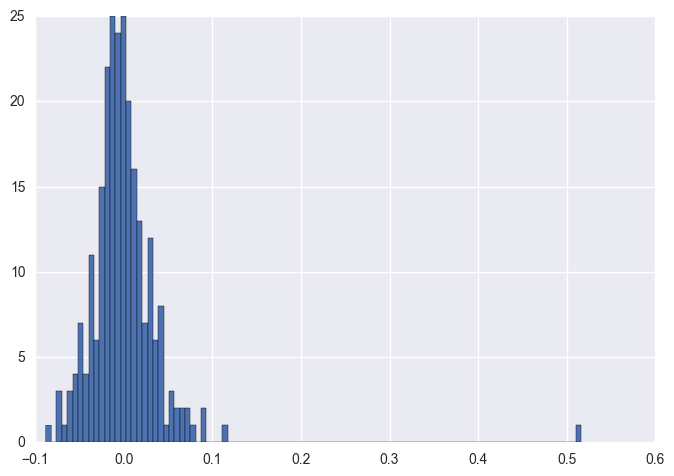

In [102]:
# BES_Panel[ 'CampaignDayW5' ].corr(W5_cats_df)
W5_cats_df.corrwith(BES_Panel[ 'CampaignDayW5' ]).sort_values().hist(bins=100)

In [87]:
# 283 with "W5" in
# 248 with "W5" in AND category

W5cats = [x for x in BES_Panel.columns if ("W5" in x) & (BES_Panel[x].dtype.name =='category')]


In [94]:
W5_cats_df = BES_Panel[W5cats].apply(lambda x : x.cat.codes).replace(-1,np.nan)

In [93]:
BES_Panel["selfNumEmployeesLastW6W7W8W9"].value_counts()

1.0       139
2.0        16
3.0         8
9999.0      1
Name: selfNumEmployeesLastW6W7W8W9, dtype: int64

In [44]:
BES_Panel["londonTurnoutW7"].cat.categories

Index(['No, did not vote', 'Yes, voted', 3.0, 4.0, 5.0, 'Don't know'], dtype='object')